In [1]:
from tensorflow import keras
from keras.models import Input, Model
from keras.layers import Dense
from pycalphad import Database, calculate, variables as v
import numpy as np

In [2]:
dbf = Database('Mg_Si_Zn.tdb')
comps = ['MG', 'SI', 'VA']

In [85]:
res = calculate(dbf, comps, 'LIQUID', T=1000, P=1e5, N=1, pdens=500)

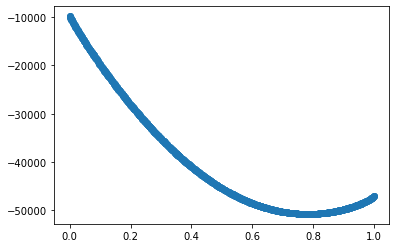

In [86]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(res.Y[..., 0], res.GM)

In [185]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from numpy.polynomial.legendre import legvander2d

x = np.squeeze(res.Y.values)
print('Number of training points: ', x.shape[0])

#x = np.c_[x, PolynomialFeatures(degree=7, include_bias=False).fit_transform(x)]
#x = np.c_[x, legvander2d(x[:, 0], x[:, 1], [2, 2]).reshape(x.shape[0], -1),
#          legvander2d(x[:, 0], x[:, 1], [1, 2]).reshape(x.shape[0], -1),
#          legvander2d(x[:, 0], x[:, 1], [2, 1]).reshape(x.shape[0], -1),
#          legvander2d(x[:, 0], x[:, 1], [2, 0]).reshape(x.shape[0], -1),
#          legvander2d(x[:, 0], x[:, 1], [0, 2]).reshape(x.shape[0], -1)]
x = np.c_[x, x[:, 0]*x[:, 1], x[:, 0]*x[:, 1]*(x[:, 0]-x[:, 1]), x[:, 0]*x[:, 1]*(x[:, 0]-x[:, 1])**2]
y = np.squeeze(res.GM.values) - 8.3145 * 1000 * (x[:, 0] * np.log(x[:, 0]) + x[:, 1] * np.log(x[:, 1]))
#y = (y - y.mean())/y.std()
print('Number of features: ', x.shape[1])
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=1769)
inputs = Input(shape=(x.shape[1],))
output = Dense(1, activation='linear', use_bias=True)(inputs)
linear_model = Model(inputs, output)
linear_model.compile(optimizer=keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True), loss='mse')

Number of training points:  1002
Number of features:  5


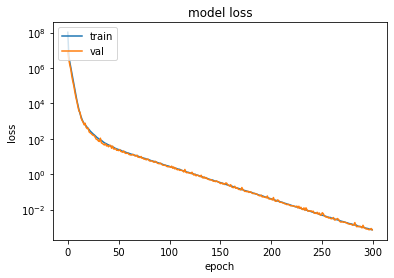

In [186]:
# Fit on training data
history = linear_model.fit(x=x_train, y=y_train, epochs=300, validation_data=(x_test, y_test), verbose=0)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.yscale('log')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Text(0, 0.5, 'Residual (J/mol)')

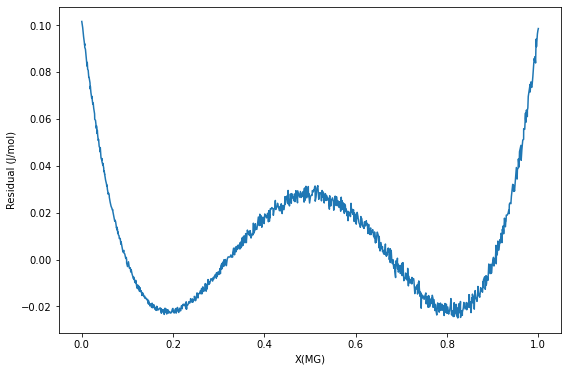

In [187]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
ax = fig.gca()
model_y = linear_model.predict(x, batch_size=1)
px_idx = np.argsort(x[:, 0])
px = x[px_idx, 0]
py = y[px_idx]
model_py = model_y[px_idx]
ax.plot(px, model_py.squeeze() - py)
ax.set_xlabel('X(MG)')
ax.set_ylabel('Residual (J/mol)')

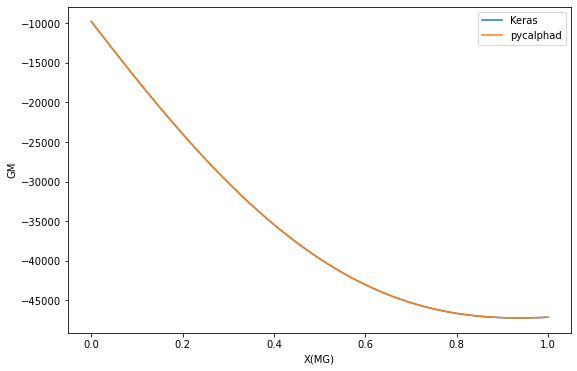

In [188]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(9,6))
ax = fig.gca()
model_y = linear_model.predict(x, batch_size=1)
px_idx = np.argsort(x[:, 0])
px = x[px_idx, 0]
py = y[px_idx]
model_py = model_y[px_idx]
ax.plot(px, model_py, label='Keras')
ax.plot(px, py, label='pycalphad')
ax.set_xlabel('X(MG)')
ax.set_ylabel('GM')
ax.legend()

In [189]:
linear_model.get_weights()

[array([[-28147.447 ],
        [  9182.552 ],
        [-45075.29  ],
        [ -1299.9907],
        [  6270.683 ]], dtype=float32),
 array([-18965.06], dtype=float32)]

In [190]:
# True Values at 1000 K: -45075.0, -1300, 6272

In [191]:
np.linalg.lstsq(x, y)

C:\Users\rotis\AppData\Local\Continuum\anaconda3\envs\calphad\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  """Entry point for launching an IPython kernel.


(array([-47112.60631554,  -9782.61031649, -45075.        ,  -1300.        ,
          6272.        ]),
 array([4.00215615e-20]),
 5,
 array([23.02462805, 13.07232179,  2.33344866,  1.19073452,  0.59975619]))